# Extracting inputs for Dynamic Benthic Pelagic Model (DBPM)
**Author:** Denisse Fierro Arcos  
**Date:** 2024-10-10  
  
We will run DBPM within the boundaries of the [Antarctic marine ecosystem (LME) region](https://celebrating200years.noaa.gov/breakthroughs/ecosystems/lme_map.jpg) as a case study. There are 66 LMEs around the world, which are defined as coastal areas that are characterised for their high productivity. Every year, 95\% of all fish catches on the planet come from LMES.  
  
To force DBPM we will use outputs from GFDL-MOM6-COBALT2, which has been regridded to a horizontal resolution of 0.25$^{\circ}$ (the original grid was 1$^{\circ}$).  
  
DBPM requires the following inputs:  
- depth  
- small phytoplankton (`phypico-vint` or mole concentration of picoplankton expressed as carbon in sea water)  
- large phytoplankton (`phyc-vint` - `phypico-vint`, where `phyc-vint`is the phytoplankton carbon concentration)  
- sea surface temperature (`tos`)  
- bottom ocean temperature (`tob`)  
- detritus (`expc-bot` or downward flux of particulate organic carbon)  

In this notebook, we describe how data was extracted from GFDL-MOM6-COBALT2 outputs to run DBPM within the Southern Ocean LME boundaries.

In [8]:
import os
os.chdir('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/python_workflow')

## Loading relevant libraries

In [9]:
import xarray as xr
import pandas as pd
import numpy as np
from glob import glob
from dask.distributed import Client
import useful_functions as uf

## Start a cluster

In [ ]:
client = Client(threads_per_worker = 1)
client

## Load Antarctic LME boundaries
Our mask includes all 66 LMEs and some FAO regions, but the value `147` identifies the Antartic LME.

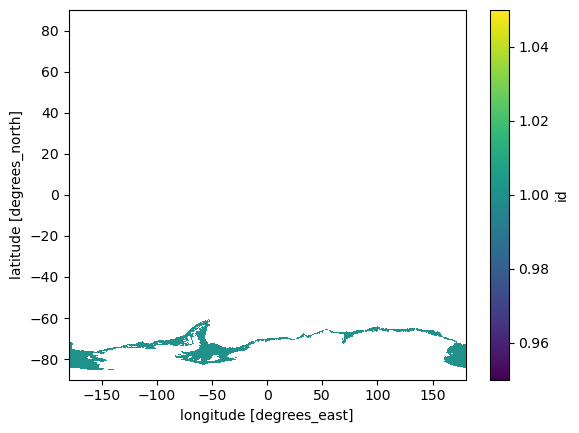

In [3]:
#Loading mask
lmes_da = xr.open_dataset('/g/data/vf71/shared_resources/fao_lme_masks/gfdl-mom6-cobalt2_fao-major_lme_15arcmin_global.nc').id
#Keeping only Antarctic LME to extract data
lmes_da = xr.where(lmes_da == 147, 1, np.nan)
#Rename dimensions to match GFDL outputs
lmes_da = lmes_da.rename({'latitude': 'lat', 'longitude': 'lon'})
lmes_da.plot()

## Load relevant GFDL-MOM6-COBALT2 outputs

In [3]:
#Base folder where GFDL outputs are stored - obsclim and ctrlclim
gfdl_obsclim = '/g/data/vf71/fishmip_inputs/ISIMIP3a/global_inputs/obsclim/025deg'
gfdl_ctrlclim = '/g/data/vf71/fishmip_inputs/ISIMIP3a/global_inputs/ctrlclim/025deg'
#Variables of interest
dbpm_var = ['deptho', 'expc-bot', 'phyc-vint', 'phypico-vint', 'tob', 'tos']
#List of relevant files
gfdl_obs_files = [glob(os.path.join(gfdl_obsclim, f'*_{var}_*'))[0] for var in dbpm_var]
gfdl_ctrl_files = [glob(os.path.join(gfdl_ctrlclim, f'*_{var}_*'))[0] for var in dbpm_var]

## Define location of outputs

In [4]:
gfdl_out = '/g/data/vf71/la6889/dbpm_inputs/gridded'
os.makedirs(gfdl_out, exist_ok = True)

## Extract data for region of interest

In [ ]:
for f in gfdl_obs_files:
    #Create file path to save outputs
    f_out = os.path.basename(f).replace('global', 'lme-61').replace('.nc', '.zarr')
    f_out = os.path.join(gfdl_out, f_out)
    #Apply function
    uf.extract_gfdl(f, lmes_da, f_out)

In [15]:
for f in gfdl_ctrl_files:
    #Create file path to save outputs
    f_out = os.path.basename(f).replace('global', 'lme-61').replace('.nc', '.zarr')
    f_out = os.path.join(gfdl_out, f_out)
    #Apply function
    uf.extract_gfdl(f, lmes_da, f_out)

## Extract area of grid cells for region of interest
We also need the area of grid cells to calculate weighted means. Both `ctrlclim` and `obsclim` experiments share the same grid, so this step needs to be completed only once.

In [7]:
area_path = '/g/data/vf71/shared_resources/grid_cell_area_ESMs/isimip3a/gfdl-mom6-cobalt2_areacello_15arcmin_global_fixed.nc'
file_out = os.path.basename(area_path).replace('global', 'lme-61').replace('.nc', '.zarr')
file_out = os.path.join(gfdl_out, file_out)
uf.extract_gfdl(area_path, lmes_da, file_out)

### Getting grid cell area values ready to be used as weights

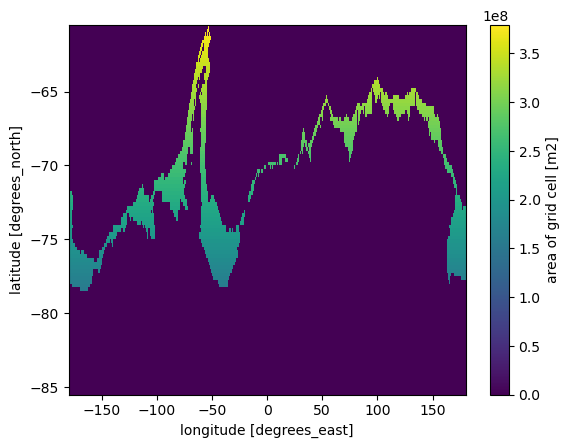

In [5]:
#Load area of grid cell to be used as weights
weights = xr.open_zarr(glob(os.path.join(gfdl_out, '*area*'))[0]).cellareao
#Areas outside LME need to be given a value of 0
weights = weights.fillna(0)
#Check result
weights.plot()

## Get list of files with data for Antarctica

In [6]:
#Get list of files to be processed
gfdl_obs_files = [glob(os.path.join(gfdl_out, f'*obsclim_{var}_*'))[0] for var in dbpm_var if var != 'deptho']
gfdl_ctrl_files = [glob(os.path.join(gfdl_out, f'*ctrlclim_{var}_*'))[0] for var in dbpm_var if var != 'deptho']
gfdl_depth = glob(os.path.join(gfdl_out, '*deptho*'))

### Define folder location for outputs

In [7]:
gfdl_out = '/g/data/vf71/la6889/dbpm_inputs/monthly_weighted_mean/'
os.makedirs(gfdl_out, exist_ok = True)

## Calculate area-weighted mean per time step
We will calculated weighted mean separately for `ctrlclim` and `obsclim` experiments.

In [9]:
#Obsclim - calculate depth separately because it does not have a time dimension
depth = uf.weighted_mean_timestep(
    [f for f in gfdl_depth if 'obsclim' in f][0],
    weights)

for i, f in enumerate(gfdl_obs_files):
    if i == 0:
        weighted_obs_df = uf.weighted_mean_timestep(f, weights)
    else:
        df = uf.weighted_mean_timestep(f, weights)
        weighted_obs_df = pd.merge(weighted_obs_df, df, on = 'time')

/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/python_workflow/useful_functions.py:66: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  new_time = da_weighted_mean.indexes['time'].to_datetimeindex()
/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/python_workflow/useful_functions.py:66: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  new_time = da_weighted_mean.indexes['time'].to_datetimeindex()
/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/python_workflow/useful_functions.py:66: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar

In [10]:
#Getting names of columns 
col_names = [i for i in weighted_obs_df.columns if i != 'time']

# Add weighted mean for depth and total area
weighted_obs_df['depth_m'] = depth
weighted_obs_df['tot_area_m2'] = weights.values.sum()
weighted_obs_df['year'] = weighted_obs_df.apply(
    lambda x: x.time.year, axis = 1)
weighted_obs_df['month'] = weighted_obs_df.apply(
    lambda x: x.time.strftime('%B'), axis = 1)
weighted_obs_df['region'] = 'LME 61'
weighted_obs_df['scenario'] = 'obsclim'

#Arrange columns 
names = ['region', 'scenario', 'time', 'year', 'month', 'depth', 'tot_area_m2'] + col_names
weighted_obs_df = weighted_obs_df[names]

#Check results
weighted_obs_df.head()

,region,scenario,time,year,month,depth,tot_area_m2,expc-bot_mol_m-2_s-1,phyc-vint_mol_m-2,phypico-vint_mol_m-2,tob_degC,tos_degC
0,LME 61,obsclim,1961-01-01,1961,January,519.051326,2.639106e+12,1.841199e-07,0.323793,0.080829,-1.337035,0.303510
1,LME 61,obsclim,1961-02-01,1961,February,519.051326,2.639106e+12,7.071567e-08,0.227868,0.117543,-1.292281,0.107454
2,LME 61,obsclim,1961-03-01,1961,March,519.051326,2.639106e+12,3.582670e-08,0.164603,0.101765,-1.278954,-0.974172
3,LME 61,obsclim,1961-04-01,1961,April,519.051326,2.639106e+12,1.597832e-08,0.078931,0.049341,-1.303040,-1.592488
4,LME 61,obsclim,1961-05-01,1961,May,519.051326,2.639106e+12,6.998199e-09,0.028267,0.018708,-1.330395,-1.759380


In [11]:
#Ctrlclim - calculate depth separately because it does not have a time dimension
depth = uf.weighted_mean_timestep(
    [f for f in gfdl_depth if 'ctrlclim' in f][0],
    weights)

for i, f in enumerate(gfdl_ctrl_files):
    if i == 0:
        weighted_ctrl_df = uf.weighted_mean_timestep(f, weights)
    else:
        df = uf.weighted_mean_timestep(f, weights)
        weighted_ctrl_df = pd.merge(weighted_ctrl_df, df, on = 'time')

/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/python_workflow/useful_functions.py:66: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  new_time = da_weighted_mean.indexes['time'].to_datetimeindex()
/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/python_workflow/useful_functions.py:66: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  new_time = da_weighted_mean.indexes['time'].to_datetimeindex()
/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/python_workflow/useful_functions.py:66: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar

In [12]:
# Add weighted mean for depth and total area
weighted_ctrl_df['depth_m'] = depth
weighted_ctrl_df['tot_area_m2'] = weights.values.sum()
weighted_ctrl_df['year'] = weighted_ctrl_df.apply(
    lambda x: x.time.year, axis = 1)
weighted_ctrl_df['month'] = weighted_ctrl_df.apply(
    lambda x: x.time.strftime('%B'), axis = 1)
weighted_ctrl_df['region'] = 'LME 61'
weighted_ctrl_df['scenario'] = 'ctrlclim'

#Arrange columns 
weighted_ctrl_df = weighted_ctrl_df[names]

#Check results
weighted_ctrl_df.head()

,region,scenario,time,year,month,depth,tot_area_m2,expc-bot_mol_m-2_s-1,phyc-vint_mol_m-2,phypico-vint_mol_m-2,tob_degC,tos_degC
0,LME 61,ctrlclim,1961-01-01,1961,January,519.051326,2.639106e+12,1.814283e-07,0.322527,0.082182,-1.335118,0.330517
1,LME 61,ctrlclim,1961-02-01,1961,February,519.051326,2.639106e+12,7.058071e-08,0.228363,0.118517,-1.291303,0.130712
2,LME 61,ctrlclim,1961-03-01,1961,March,519.051326,2.639106e+12,3.594295e-08,0.163950,0.101095,-1.279956,-0.971242
3,LME 61,ctrlclim,1961-04-01,1961,April,519.051326,2.639106e+12,1.602367e-08,0.078121,0.048714,-1.303288,-1.593834
4,LME 61,ctrlclim,1961-05-01,1961,May,519.051326,2.639106e+12,7.000150e-09,0.027814,0.018355,-1.329981,-1.760516


### Save outputs 

In [47]:
weighted_obs_df.to_parquet(
    os.path.join(gfdl_out, 'obsclim_dbpm_all-inputs_LME_61_1961-2010.parquet'), 
    index = False)

weighted_ctrl_df.to_parquet(
    os.path.join(gfdl_out, 'ctrlclim_dbpm_all-inputs_LME_61_1961-2010.parquet'), 
    index = False)

## Creating **spinup** period
We will use data from `ctrlclim` between 1961 and 1980 as our spinup period. Our spinup period will go from 1841 to 1960.

In [48]:
#Extract data between 1961 and 1980
spinup = weighted_ctrl_df[(weighted_ctrl_df.year >= 1961) & (weighted_ctrl_df.year <= 1980)]
spinup.head()

,region,scenario,time,year,month,depth_m,tot_area_m2,expc-bot_mol_m-2_s-1,phyc-vint_mol_m-2,phypico-vint_mol_m-2,tob_degC,tos_degC
0,LME 61,ctrlclim,1961-01-01,1961,January,519.051326,2.639106e+12,1.814283e-07,0.322527,0.082182,-1.335118,0.330517
1,LME 61,ctrlclim,1961-02-01,1961,February,519.051326,2.639106e+12,7.058071e-08,0.228363,0.118517,-1.291303,0.130712
2,LME 61,ctrlclim,1961-03-01,1961,March,519.051326,2.639106e+12,3.594295e-08,0.163950,0.101095,-1.279956,-0.971242
3,LME 61,ctrlclim,1961-04-01,1961,April,519.051326,2.639106e+12,1.602367e-08,0.078121,0.048714,-1.303288,-1.593834
4,LME 61,ctrlclim,1961-05-01,1961,May,519.051326,2.639106e+12,7.000150e-09,0.027814,0.018355,-1.329981,-1.760516


Repeating data six times to create a spinup cycle of 120 years from 1841 to 1960.

In [49]:
#Create a vector with dates within spinup period
spinup_period = pd.date_range('1841-01-01', end = '1960-12-31', freq = 'MS')

#Create data frame that matches spinup period
spinup_df = pd.concat([spinup, spinup], axis = 0)
while len(spinup_df) < len(spinup_period):
    spinup_df = pd.concat([spinup_df, spinup], axis = 0)

Replaces dates in data frame with spinup period and relabel `scenario` as *spinup*.

In [50]:
spinup_df['time'] = spinup_period
#Year needs to be updated to match new spinup period
spinup_df['year'] = spinup_df.apply(
    lambda x: x.time.year, axis = 1)
spinup_df['scenario'] = 'spinup'

#Check results
spinup_df.head()

,region,scenario,time,year,month,depth_m,tot_area_m2,expc-bot_mol_m-2_s-1,phyc-vint_mol_m-2,phypico-vint_mol_m-2,tob_degC,tos_degC
0,LME 61,spinup,1841-01-01,1841,January,519.051326,2.639106e+12,1.814283e-07,0.322527,0.082182,-1.335118,0.330517
1,LME 61,spinup,1841-02-01,1841,February,519.051326,2.639106e+12,7.058071e-08,0.228363,0.118517,-1.291303,0.130712
2,LME 61,spinup,1841-03-01,1841,March,519.051326,2.639106e+12,3.594295e-08,0.163950,0.101095,-1.279956,-0.971242
3,LME 61,spinup,1841-04-01,1841,April,519.051326,2.639106e+12,1.602367e-08,0.078121,0.048714,-1.303288,-1.593834
4,LME 61,spinup,1841-05-01,1841,May,519.051326,2.639106e+12,7.000150e-09,0.027814,0.018355,-1.329981,-1.760516


In [51]:
spinup_df.to_parquet(
    os.path.join(gfdl_out, 'spinup_dbpm_all-inputs_LME_61_1841-1960.parquet'), 
    index = False)